# Plants - frequent itemset mining

Use of external resources:


* [Pandas documentation](https://pandas.pydata.org/docs/index.html)
* [Matplotlib documentation](https://matplotlib.org/stable/index.html)
* [StackOverFlow discussion](https://stackoverflow.com/questions/57975146/how-to-properly-plot-bar-chart-with-matplotlib)
* [NetworkX documentation](https://networkx.org/documentation/stable/reference/index.html)

Collaboration:


*   No collaboration



Required libraries:

In [153]:
# standard / 3rd party
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.typing import NDArray

# local
from pyfim import *

## Data presentation

**Brief description**

Data (URL for the dataset [here](https://archive.ics.uci.edu/dataset/180/plants)) contain all plants and states of USA and Canada where they occur. The dataset is already in transactional form and, therefore, contains a categorical data. Together with a latin name, there are state abbreviations for each species (transaction).

**Data presentation**

Similar to the voting dataset, first, we need to load the dataset. We tried to use pandas library for the job but it seems to struggle with transactional data, thus, we will process it by ourselves.

In [154]:
PATH = "./plants.data"

dataset = []

with open(PATH, "r", encoding='ISO-8859-1') as f:
    for line in f.readlines():
        items = line.strip("\n").split(",")
        dataset.append( set(items) )

for i in range(10):
    print(dataset[i])

{'fl', 'nc', 'abelia'}
{'abelia x grandiflora', 'nc', 'fl'}
{'md', 'ms', 'nc', 'fl', 'ct', 'il', 'sc', 'mi', 'dc', 'abelmoschus', 'ky', 'la', 'va', 'vi', 'pr', 'hi'}
{'md', 'ms', 'nc', 'fl', 'ct', 'il', 'sc', 'mi', 'dc', 'va', 'ky', 'la', 'vi', 'abelmoschus esculentus', 'pr'}
{'abelmoschus moschatus', 'pr', 'hi'}
{'on', 'ct', 'nf', 'nh', 'mb', 'nt', 'wy', 'me', 'in', 'ak', 'mn', 'vt', 'md', 'nc', 'mt', 'mi', 'ma', 'co', 'wa', 'ns', 'fraspm', 'oh', 'ri', 'tn', 'nu', 'lb', 'qc', 'nb', 'wi', 'pa', 'bc', 'az', 'ab', 'sk', 'wv', 'ca', 'or', 'nv', 'ut', 'abies', 'pe', 'id', 'yt', 'ia', 'va', 'ny', 'nm', 'ga'}
{'abies alba', 'nc'}
{'ca', 'or', 'bc', 'wa', 'ak', 'abies amabilis'}
{'on', 'ct', 'nf', 'nh', 'mb', 'me', 'in', 'vt', 'mn', 'md', 'mi', 'ma', 'ns', 'abies balsamea', 'fraspm', 'oh', 'ri', 'qc', 'nu', 'lb', 'nb', 'wi', 'pa', 'ab', 'sk', 'wv', 'pe', 'ia', 'va', 'ny'}
{'on', 'ct', 'nf', 'abies balsamea var. balsamea', 'nh', 'mb', 'me', 'in', 'vt', 'mn', 'md', 'mi', 'ma', 'ns', 'fraspm', '

Note that the transactions indeed contain a latin name of a plant together with states in which they occur (in US and Canada). Since the latin name can hardly be considered an item, we can handle it as identifier of each transaction, while the individual states represent items. For that reason, we remove plant names from the transactions.

In [155]:
filtered = []
labels = []

for t in dataset:

    sample = set()
    for item in t:
        if not (len(item) == 2 or item in ["dengl", "fraspm"]):
            labels.append( item )
        else:
            sample.add(item)

    filtered.append( sample )

dataset = filtered

In [156]:
for i in range(10):
    print(labels[i], dataset[i])

abelia {'nc', 'fl'}
abelia x grandiflora {'nc', 'fl'}
abelmoschus {'md', 'ms', 'nc', 'fl', 'ct', 'il', 'sc', 'mi', 'dc', 'va', 'ky', 'la', 'vi', 'pr', 'hi'}
abelmoschus esculentus {'md', 'ms', 'nc', 'fl', 'ct', 'il', 'sc', 'mi', 'dc', 'va', 'ky', 'la', 'vi', 'pr'}
abelmoschus moschatus {'pr', 'hi'}
abies {'on', 'nm', 'ct', 'nf', 'nh', 'mb', 'nt', 'wy', 'me', 'in', 'ak', 'vt', 'mn', 'md', 'nc', 'mi', 'ma', 'co', 'wa', 'ns', 'fraspm', 'oh', 'ri', 'tn', 'nu', 'lb', 'qc', 'nb', 'wi', 'pa', 'bc', 'az', 'ab', 'sk', 'wv', 'ca', 'or', 'nv', 'ut', 'pe', 'id', 'yt', 'ia', 'va', 'ny', 'mt', 'ga'}
abies alba {'nc'}
abies amabilis {'ca', 'or', 'bc', 'wa', 'ak'}
abies balsamea {'on', 'ct', 'nf', 'nh', 'mb', 'me', 'in', 'mn', 'vt', 'md', 'mi', 'ma', 'ns', 'fraspm', 'oh', 'ri', 'qc', 'nu', 'lb', 'nb', 'wi', 'pa', 'ab', 'sk', 'wv', 'pe', 'ia', 'va', 'ny'}
abies balsamea var. balsamea {'on', 'ct', 'nf', 'nh', 'mb', 'me', 'in', 'mn', 'vt', 'md', 'mi', 'ma', 'ns', 'fraspm', 'oh', 'ri', 'qc', 'nu', 'lb', '

In [157]:
print("# of transactions: ", len(dataset))
n = len(dataset)

mx = -1
for t in dataset:
    mx = max(mx, len(t))

print("max # of items in transaction: ", mx)

# of transactions:  34781
max # of items in transaction:  69


We can see that we have 34781 plants and the most common plant is located in 69 states.

Next, let us have a look at the state occurences.

<ipython-input-158-78e871fe5c5e>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=90)


<BarContainer object of 70 artists>

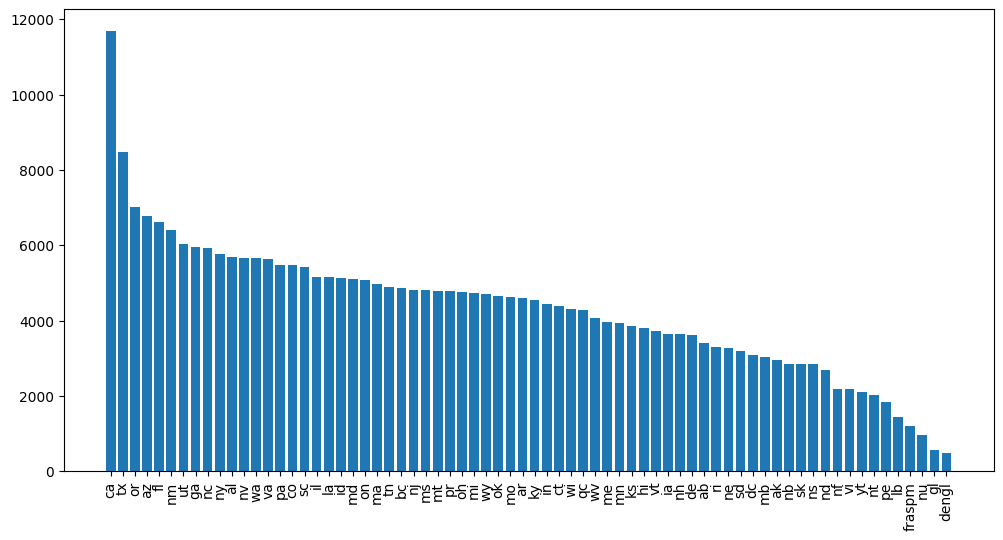

In [158]:
frequencies = {}

for t in dataset:
    for item in t:

        if not (len(item) == 2 or item in ["dengl", "fraspm"]):
            continue

        if item not in frequencies:
            frequencies[item] = 0
        frequencies[item] += 1

labels = []
heights = []
for a, b in sorted(frequencies.items(), key=lambda x: x[1], reverse=True):
    labels.append(a)
    heights.append(b)

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xticklabels(labels, rotation=90)
ax.bar(labels, heights)

It can be seen that California and Texas have the most colorful flora (California leading by great margin). At first, this observation might be a bit un-intuitive since there are large desert areas in these states, however, we need to be mindful of the fact that there is a
sprawling national park - Yosemite located in California (besides other factors like size etc.).

Since the dataset is already in the transactional form and there are not other faults (missing value, rescaling, etc.), we do not need to preprocess it any further.

## Frequent itemset mining

We are going to perform similar analysis and mining technique as demonstrated with voting dataset. First, let us try to set a relative support threshold to 10% without any additional conditions.

In [159]:
freqs = fim(dataset, target='s', supp=10)
print("# frequent itemsets: ", len(freqs))

# frequent itemsets:  358


(Excerpt from the function for printing frequent itemsets used for voting dataset)

In [160]:
def print_frequent(freqs) -> None:
    for freq in sorted(freqs, key=lambda x: -x[1])[:10]:
        print("(" + " ".join(list(freq[0])) + ")", freq[1], f"{(freq[1] / n * 100):.1f}%")

In [161]:
print_frequent(freqs)

(ca) 11676 33.6%
(tx) 8483 24.4%
(or) 7028 20.2%
(az) 6778 19.5%
(fl) 6621 19.0%
(nm) 6403 18.4%
(ut) 6041 17.4%
(ga) 5942 17.1%
(nc) 5926 17.0%
(ny) 5773 16.6%


Not surprisingly, the most frequent itemsets are again singletons. Similar to the previous datasets, these bring a very little information since their frequency is already captured in the histogram presented in the previous section.

Let's try to obtain only closed frequent itemsets with at least 3 items.

In [162]:
freqs = fim(dataset, target='c', supp=10, zmin=3)
print("# frequent itemsets: ", len(freqs))
print_frequent(freqs)

# frequent itemsets:  142
(sc nc ga) 4447 12.8%
(sc al ga) 4322 12.4%
(al nc ga) 4246 12.2%
(sc al nc) 4148 11.9%
(va ga nc) 4124 11.9%
(sc va nc) 4068 11.7%
(ms ga al) 4049 11.6%
(sc al nc ga) 4038 11.6%
(md nc va) 4026 11.6%
(nj pa ny) 3985 11.5%


We observe that the number of frequent itemsets dropped (expectedly). These itemsets bring us some interesting information though. It may indicate groups of states with similar flora. For instance North Carolina, South Carolina, and Georgia are states close to each other, which suggest that their flora might indeed be similar. This observation holds for other itemsets as well.

Notice that we set the relative support threshold quite high, therefore, there is a little number of frequent itemsets.

In [163]:
freqs = fim(dataset, target='c', supp=7, zmin=2)
print("# frequent itemsets: ", len(freqs))
print_frequent(freqs)

# frequent itemsets:  41287
(or ca) 5522 15.9%
(wa or) 4959 14.3%
(al ga) 4931 14.2%
(va nc) 4854 14.0%
(nc ga) 4833 13.9%
(sc ga) 4821 13.9%
(sc nc) 4800 13.8%
(nm az) 4723 13.6%
(nv ca) 4701 13.5%
(pa ny) 4652 13.4%


We see that if we decrease the threshold just a little bit, we get drastically more frequent itemsets.

## Association rule inference

Finally, we are going to to infer some association rules with high confidence implied by the data. For that, we are going to mine frequent itemset with relative support of 8% (we tried several thresholds and this gives us a suitable amount of frequent itemsets).

In [164]:
freqs = fim(dataset, target='s', supp=8, zmin=1)
print("# frequent itemsets: ", len(freqs))
print_frequent(freqs)

# frequent itemsets:  5600
(ca) 11676 33.6%
(tx) 8483 24.4%
(or) 7028 20.2%
(az) 6778 19.5%
(fl) 6621 19.0%
(nm) 6403 18.4%
(ut) 6041 17.4%
(ga) 5942 17.1%
(nc) 5926 17.0%
(ny) 5773 16.6%


Next, we are going to use functions already presented in `fim_voting` notebook.

In [165]:
def conf(freq_map, x, y):
    """
    return confidence of rules <x> -> <y>
    based on support counts in <freq_map>
    """
    xy = tuple( set(x) | set(y) )

    return freq_map[ tuple( sorted(xy) ) ] / freq_map[ tuple( sorted(x) ) ]

In [166]:
from itertools import combinations

def association_rules(freq_map, thr):
    rules = []
    for itemset, _ in freq_map.items():
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                consequent = tuple( set(itemset) - set(antecedent) )

                if len(consequent) == 0:
                    continue

                c = conf(freq_map, antecedent, consequent)
                if c >= thr:
                    rules.append( ( [antecedent, consequent], c ) )

    return rules

In [167]:
def print_rules(rules):
    for rule, c in sorted(rules, key=lambda x: -x[1])[:10]:
        a = "(" + " ".join(list(rule[0])) + ")"
        b = "(" + " ".join(list(rule[1])) + ")"
        print( f"{a} -> {b} (conf={c:.2f})" )

The previous code had couple of problems. First, since we mined only itemsets of consisting of at least 2 items, it was not able to infer rules where either X or Y would be singleton itemset. Second, since we did not use any specific ordering, it might happen that we missed some rules because we did not find them in our itemset frequency map. Those bugs should be fixed now (same for voting notebook).

Now, we are going to convert our set of frequent itemsets into dictionary and infere association rules. We set the confidence threshold to 80% (same as for voting dataset).

In [168]:
freq_map = {}
for a, b in freqs:
    freq_map[ tuple( sorted(a) ) ] = b

In [169]:
rules = association_rules(freq_map, 0.80)
print(len(rules))

61916


In [170]:
print_rules(rules)

(ct ma nj pa vt) -> (ny) (conf=1.00)
(ma nj pa vt) -> (ny) (conf=1.00)
(ct ma nj pa wi) -> (ny) (conf=1.00)
(ct mi nj pa wi) -> (ny) (conf=1.00)
(ct nj pa vt) -> (ny) (conf=1.00)
(ct nh nj pa) -> (ny) (conf=1.00)
(ct ma mi nj on pa) -> (ny) (conf=1.00)
(ct ma nh nj pa) -> (ny) (conf=1.00)
(ma mi nj pa wi) -> (ny) (conf=1.00)
(mi nj on pa wi) -> (ny) (conf=1.00)


We observe very high confidence for the top rules (Similar for the voting dataset). Also, it is nicely visible how presence of certain plants imply presence of the same species in other states. By this, I mean that there is a very high probability that if a certain plant grows in "ct", "ma", "nj", "pa", and "vt", it will also grow in "ny".

Finally, let us try to filter rules with consequent of length at least two:

In [171]:
rules_2 = []
for rule, c in rules:
    if len(rule[1]) >= 2:
        rules_2.append( (rule, c) )

In [172]:
print( len(rules_2) )

41338


In [173]:
print_rules(rules_2)

(ct nh nj pa) -> (ma ny) (conf=1.00)
(ct nh nj) -> (ma ny) (conf=0.99)
(ct ma md wv) -> (pa ny) (conf=0.99)
(ct ma md nj oh) -> (pa ny) (conf=0.99)
(ct ma md nj oh va) -> (pa ny) (conf=0.99)
(ct in ma nj oh) -> (pa ny) (conf=0.99)
(ct il ma md oh) -> (pa ny) (conf=0.99)
(ct ma oh wv) -> (pa ny) (conf=0.99)
(ct ma nj oh on) -> (pa ny) (conf=0.99)
(ct nh pa) -> (ma ny) (conf=0.99)


Again, we observe rules with "ny" being a part of the consequent of all the top rules. I can imagine that such rules could be used to create a flora similarity map of states. By similarity map, I mean a graph whose nodes would be individual states, and there would be an edge from state X to state Y if the confidence of rule X -> Y is above certain threshold.

In [174]:
edges = []
for rule, c in rules:
    if len(rule[0]) == 1 and len(rule[1]) == 1:
        edges.append( (rule[0][0], rule[1][0]) )

In [175]:
len(edges)

166

We can draw strongly connected components of such graph:

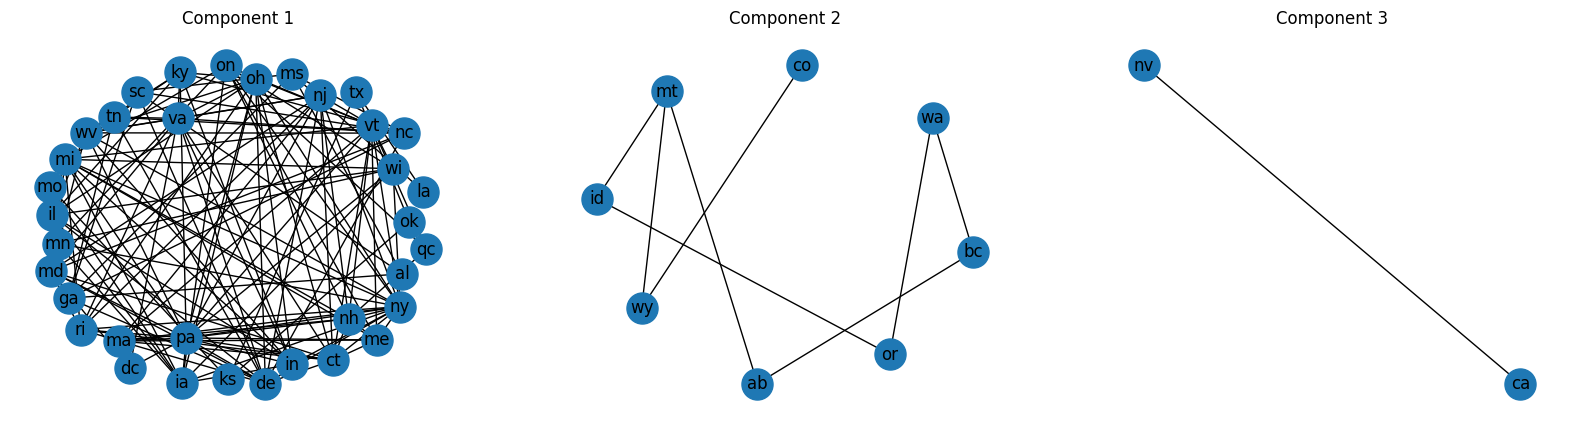

In [176]:
import networkx as nx

G = nx.Graph()
G.add_edges_from(edges)

components = list(nx.connected_components(G))


plt.figure(figsize=(20, 5))

for i, component in enumerate(components):

    subgraph = G.subgraph(component)
    pos = nx.spring_layout(subgraph, k=4, iterations=50)
    plt.subplot(1, len(components), i + 1)
    nx.draw(subgraph, pos, with_labels=True, node_size=500, font_size=12)
    plt.title(f"Component {i + 1}")

plt.show()

We can see that "ca" has similar flora to "nv". This is not surprising since they are neighbouring states with a common geography. Then we see that north-western states (also Canadian) create one connected group, and the rest is in the last big component.